In [655]:
import json
from datetime import datetime
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import scipy as sp
import statsmodels.api as sm
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
%matplotlib inline  

In [681]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [693]:
def plot_precision_recall(precision,recall,threshold):
    # Plot Precision-Recall curve
    plt.plot(threshold, precision, label='Precision')
    plt.plot(threshold, recall, label='Recall')
    plt.xlabel('Threshold')
    plt.title('Precision And Recall')
    plt.legend(loc="upper right")
    plt.show()
    
def plot_roc_pr(pred,correct_label,recall_atleast=None):
    fpr, tpr, roc_thres = roc_curve(correct_label,pred)
    roc_auc = auc(fpr, tpr)
    print 'auc roc: %.3g ' %(roc_auc,)
    precision, recall, pr_thres = precision_recall_curve(correct_label,pred)
    pr_thres = [0]+list(pr_thres)
    plt.figure(figsize=(12, 8))
    # roc curve 
    plt.subplot(121)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3g)' % (roc_auc,))
    plt.legend()
    plt.xlabel('FPR');plt.ylabel('TPR')
    plt.title('ROC plot')
    # Precision recall curve
    plt.subplot(122)
    plot_precision_recall(precision,recall,pr_thres)
    plt.show()
    return roc_auc

def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

def performance_report(data_cv,features,preds,label,cutoff=0.5):
    ct = pd.crosstab(data_cv[label].values,(preds>=cutoff).astype(int))
    print(ct)
    recall = ct.ix[1,1]*1.0 / (ct.ix[1,0]+ct.ix[1,1])
    precision = ct.ix[1,1] * 1.0 / (ct.ix[0,1]+ct.ix[1,1])
    accuracy = (ct.ix[0,0] + ct.ix[1,1])*1.0 / sum(ct.sum())
    print 'recall: %.3g ' %(recall,)
    print 'precision: %.3g ' %(precision,)
    print 'accuracy: %.3g' %(accuracy,)
    logloss_ = logloss(data_cv[label],preds)
    print 'logloss: %.3g' %(logloss_,)
    roc = plot_roc_pr(preds,data_cv[label])
    plt.savefig('report.png')
    return([recall,precision,accuracy,logloss_,roc])

In [3]:
with open('uber_data_challenge.json') as data_file:    
    data = json.load(data_file)

In [8]:
data = pd.DataFrame(data)

In [9]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [10]:
data.shape

(50000, 12)

In [12]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

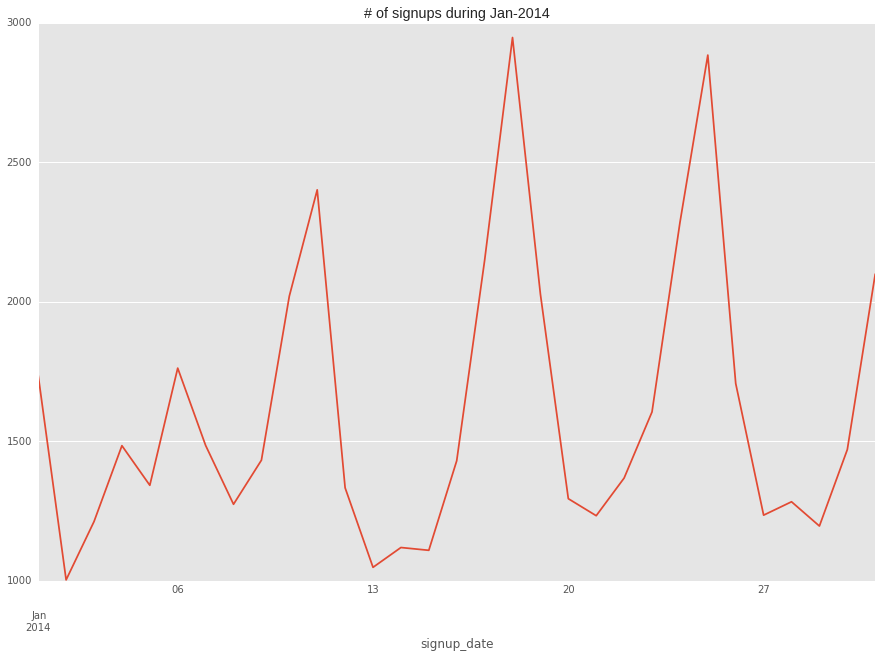

In [579]:
data.groupby(['signup_date']).size().plot()
plt.title('# of signups during Jan-2014')
plt.savefig('signup_date.png')

In [21]:
cat_cols = {'city','phone','uber_black_user'}
num_cols = set(data._get_numeric_data().columns) - cat_cols 
print 'Categorical Cols: {}'.format(', '.join(list(cat_cols)))
print 'Numerical Cols: {}'.format(', '.join(list(num_cols)))

Categorical Cols: uber_black_user, city, phone
Numerical Cols: avg_dist, avg_rating_of_driver, avg_surge, surge_pct, weekday_pct, trips_in_first_30_days, avg_rating_by_driver


In [27]:
data['active'] = (data['last_trip_date']>='2014-06-01').astype(int)

In [691]:
data.groupby('city')['active'].mean()


city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: active, dtype: float64

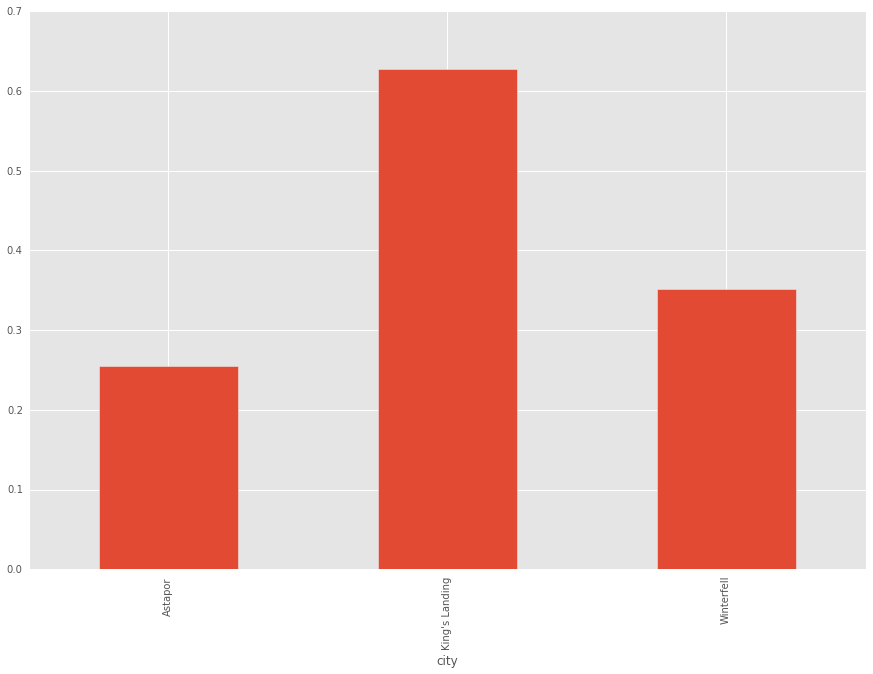

In [690]:
data.groupby('city')['active'].mean()
data.groupby('city')['active'].mean().plot(kind='bar')
plt.savefig('city.png')

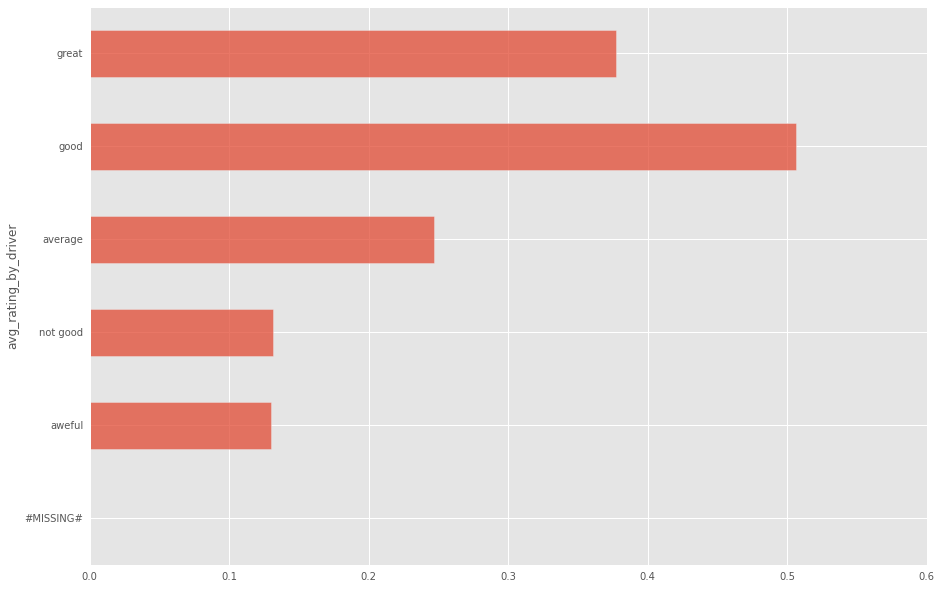

In [575]:
train_added.groupby('avg_rating_by_driver')['active'].mean().plot(kind='barh',alpha=.75)
plt.savefig('avg_rating_by_driver.png')

In [96]:
1. * sum(data['active']) / len(data)

0.37608

In [60]:
# Set seed to generate reproducible results
np.random.seed(816)

In [61]:
train_msk = (np.random.uniform(0,1,len(data)) <= 0.7)

Seperate training and testing data (70%/30%), all exploratory analysis will be based on the training dataset moving forward to avoid any bias

In [129]:
train = data.ix[train_msk].reset_index(drop=True)
test = data.ix[~train_msk].reset_index(drop=True)

In [533]:
def preprocess_features(data,cat_cols,num_cols):
    """ Add features to existing data set, and return dataframe and a list of all the features
        preprocess features: clip outliers for numeric features and fill in missing values 
    """
    cat_cols = list(cat_cols)
    num_cols = list(num_cols)
    # for numerica values, fillin missing values with median 
    for col in num_cols:
        data[col].fillna(data[col].median(),inplace=True)
    # Add some potentially useful features
    #data['DayofWeekSignup'] = [date.strftime('%a') for date in data['signup_date']]
    # Transform avg_rating_of_driver to bins [-1,1,2] == (-1,1], (1,2]
    data['avg_rating_of_driver'] = pd.cut(data['avg_rating_of_driver'],bins=[-np.inf,-1,2,3,4,4.5,5]
                                          ,labels=['#MISSING#','aweful','not good','average','good','great'])
    data['avg_rating_by_driver'] = pd.cut(data['avg_rating_by_driver'],bins=[-np.inf,-1,2,3,4,4.5,5]
                                          ,labels=['#MISSING#','aweful','not good','average','good','great'])
    data['surge_pct'] = pd.cut(data['surge_pct'],bins=[-np.inf,-1,10,20,40,100]
                              ,labels=['#MISSING#','low','bit more','over average','high'])
    data['avg_dist'] = pd.cut(data['avg_dist'],bins=[-np.inf,-1,1,2,5,10,20,np.inf]
                             ,labels=['#MISSING#','low','bit more','over average','high','really high','extreme high'])
    data['trips_in_first_30_days'] = pd.cut(data['trips_in_first_30_days'],bins=[-np.inf,-1,0,1,2,3,5,10,20,np.inf]
                                           ,labels = ['#MISSING#','0','1','2','3','3-5','5-10','10-20','>20'])
    # Remove avg_rating_of_driver
    num_cols_remove = ['avg_rating_of_driver','surge_pct','avg_dist','trips_in_first_30_days','avg_rating_by_driver']
    num_cols = [x for x in num_cols if x not in num_cols_remove]
    cat_cols += ([] + num_cols_remove)
    # Initalize the feature list 
    features = []
    # Calculate probablity for categorical features, fillin '#MISSING#' for categorical missing values 
    for col in cat_cols:
        data[col].fillna('#MISSING#',inplace=True)
        data[col+'_p'] = data.groupby(col)['active'].transform('mean')
        features.append(col+'_p')
    
    return (data,features)

In [645]:
train_added,features = preprocess_features(train.copy(),cat_cols,num_cols)
test_added,features = preprocess_features(test.copy(),cat_cols,num_cols)

In [580]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_dist,35133,5.81153,5.71035,0,2.42,3.89,6.96,160.96
avg_rating_by_driver,34989,4.77657,0.447498,1,4.7,5,5,5
avg_rating_of_driver,29479,4.60015,0.621501,1,4.4,4.9,5,5
avg_surge,35133,1.07508,0.225446,1,1,1,1.05,8
surge_pct,35133,8.77133,19.7865,0,0,0,8.3,100
trips_in_first_30_days,35133,2.29155,3.8147,0,0,1,3,125
uber_black_user,35133,0.379216,0.485199,False,0,0,1,True
weekday_pct,35133,60.9746,37.0084,0,33.3,66.7,100,100
active,35133,0.37822,0.48495,0,0,0,1,1


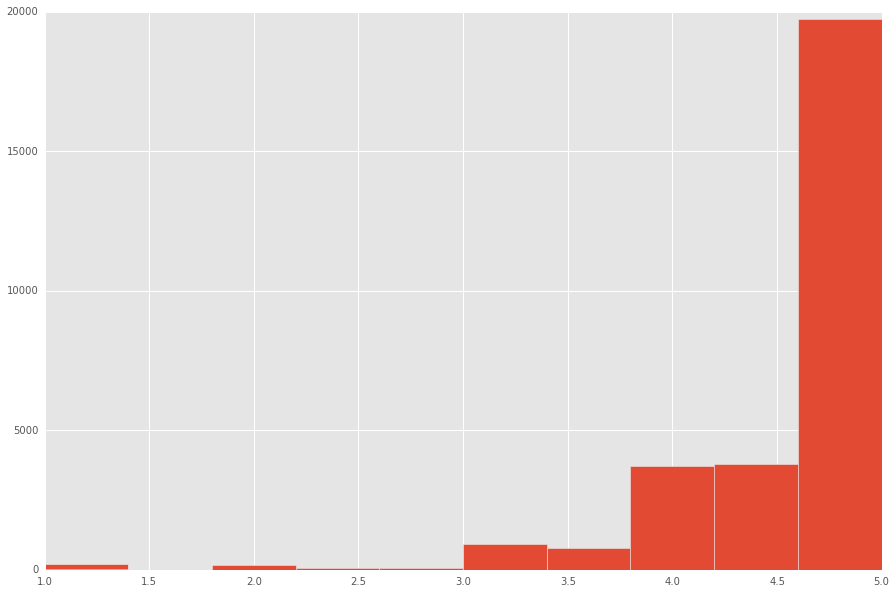

In [686]:
train['avg_rating_of_driver'].hist()
plt.savefig('ha1.png')

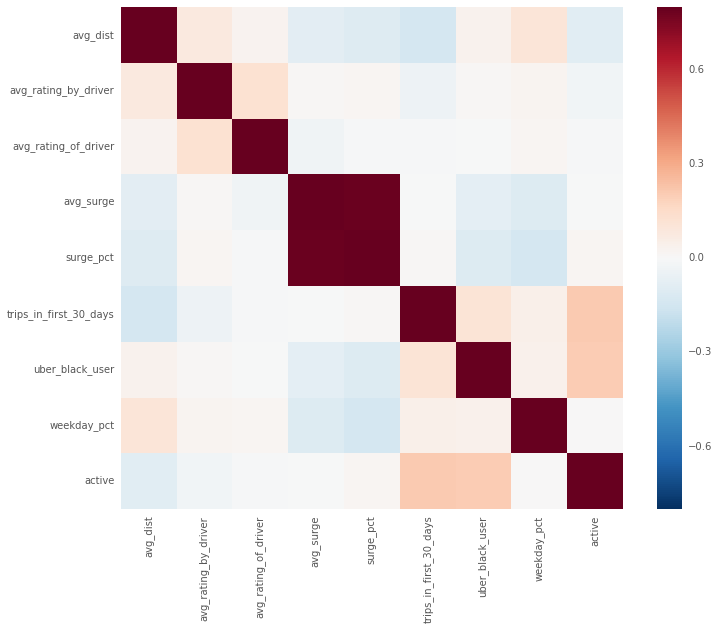

In [689]:
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(train.corr(), vmax=.8, square=True)
plt.savefig('corr.png')

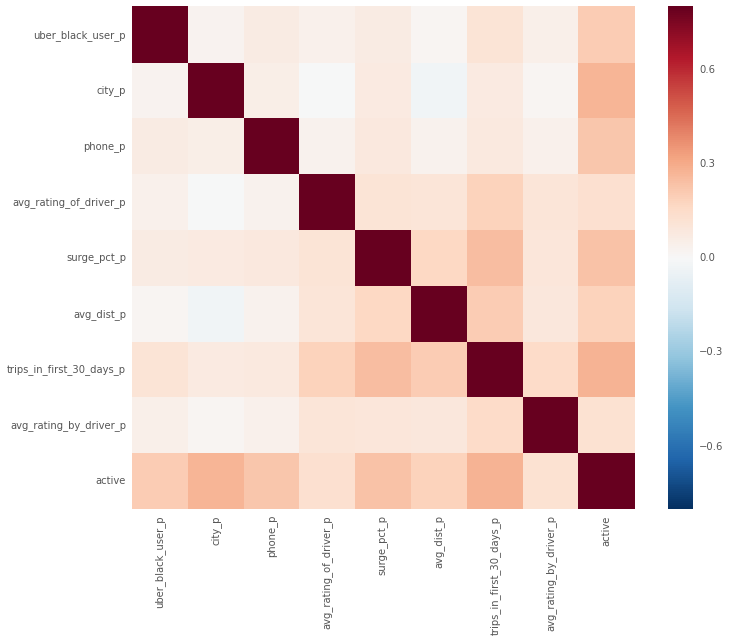

In [511]:
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(train_added[features+['active']].corr(), vmax=.8, square=True)

From plot above, we observe that avg_surge and surge_pct have high correlation, which makes sense since if a user has high avg_surge, that means more likely he would also have a high surge pct. We only use surge_pct for now to see how it works

In [607]:
p = int(0.7 * len(train))
data_train = train_added.ix[:p,].reset_index(drop=True)
data_cv = train_added.ix[p:,].reset_index(drop=True)

First try out the simplest model such as Logistic regression and Naive Bayes

Try Logistic Regression

In [656]:
data_train['intercept'] = 1 
logit = sm.Logit(data_train['active'], data_train[features+['intercept']])
model = logit.fit()

Optimization terminated successfully.
         Current function value: 0.532106
         Iterations 6


                           Logit Regression Results                           
Dep. Variable:                 active   No. Observations:                24594
Model:                          Logit   Df Residuals:                    24585
Method:                           MLE   Df Model:                            8
Date:                Thu, 18 Aug 2016   Pseudo R-squ.:                  0.1983
Time:                        17:59:24   Log-Likelihood:                -13087.
converged:                       True   LL-Null:                       -16324.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
uber_black_user_p            3.8792      0.153     25.421      0.000         3.580     4.178
city_p                       4.5722      0.115     39.783      0.000         4.347     4.

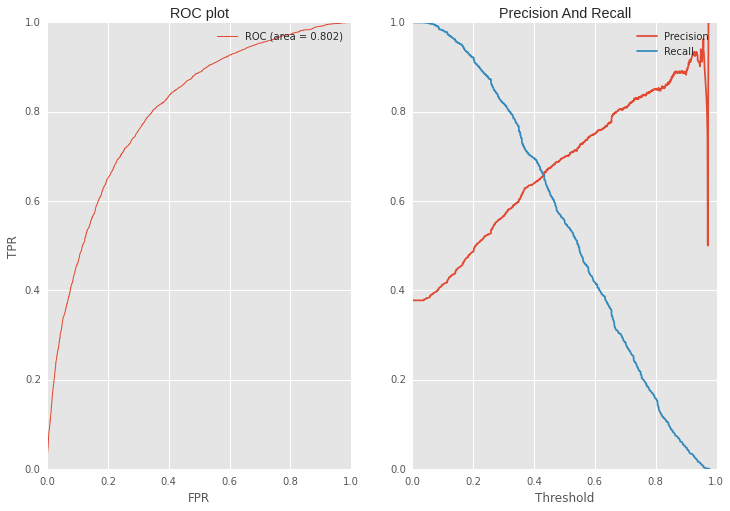

In [694]:
print(model.summary())
data_cv['intercept'] =1 
preds = model.predict(data_cv[features+['intercept']])
report = performance_report(data_cv,features,preds,'active')

Test result of Logistic regression

In [ ]:
test_added['intercept'] = 1 
preds = model.predict(test_added[features+['intercept']])
report = performance_report(test_added,features,preds,'active')

Try Navie Bayes Classifier

col_0     0     1
row_0            
0      5359  1222
1      1629  2330
recall: 0.589 
precision: 0.656 
accuracy: 0.73
logloss: 0.645
auc roc: 0.784 


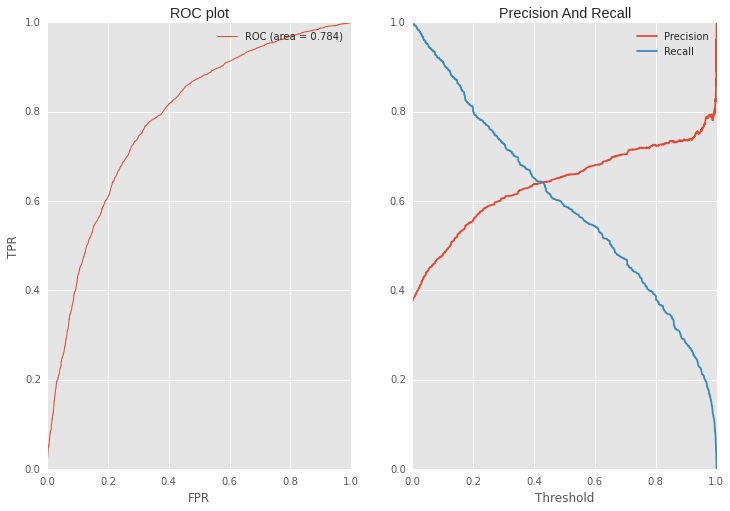

In [671]:
clf = GaussianNB()
clf.fit(data_train[features],data_train['active'])
preds = clf.predict_proba(data_cv[features])[:,1]
report = performance_report(data_cv,features,preds,'active')

Test result of Naive Bayes

col_0     0     1
row_0            
0      7808  1543
1      2475  3041
recall: 0.551 
precision: 0.663 
accuracy: 0.73
logloss: 0.641
auc roc: 0.781 


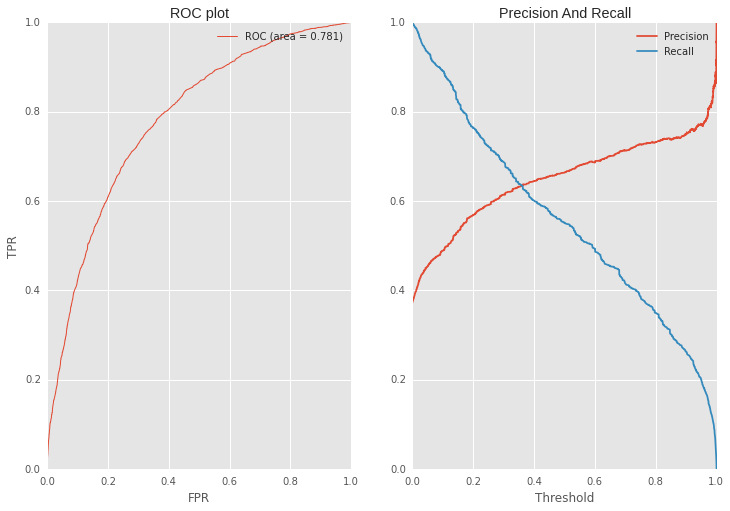

In [674]:
preds = clf.predict_proba(test_added[features])[:,1]
report = performance_report(test_added,features,preds,'active')

Notice that there are class inbalance between active and inactive, try sample 1:1 for training

In [ ]:
### Futhur steps

try apply PCA transform to see if it would improve performance

In [ ]:
### Further steps

try some other more complicated models like Gradient Boosting Machine, here we use xgboost implementation

In [675]:
def modelfit(alg,dtrain,dtest,features,target,useTrainCV=True,cv_folds=5,early_stopping_rounds=10):
    """ Fit xgboost classfier on train and cv dataset, and return the trained clf and training result
        Plot variable importance at the end
    """
    predictors = [x[:-2].replace('_','') for x in features]
    dtrain.columns = dtest.columns = (predictors+[target])
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param.update({'eval_metric': 'logloss','early_stopping_rounds':early_stopping_rounds })
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds)
        print 'Best iteration: %s' %np.argmin(cvresult.get_values()[:,0])
        alg.set_params(n_estimators=np.argmin(cvresult.get_values()[:,0]))
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    ll = logloss(dtest[target] , alg.predict_proba(dtest[predictors])[:,1])
    
    #Print model report:
    print "\nModel Report"
    print "Logloss: %.6g" %ll
    print "Accuracy : %.6g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('Feature_imp.png')
    return cvresult,alg

In [643]:
xgb1 = XGBClassifier(
 learning_rate =0.02,
 n_estimators=300,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 #eval_metric = 'logloss',
 nthread=4,
 seed=27)

Best iteration: 296

Model Report
Logloss: 0.509084
Accuracy : 0.752623
AUC Score (Train): 0.815136


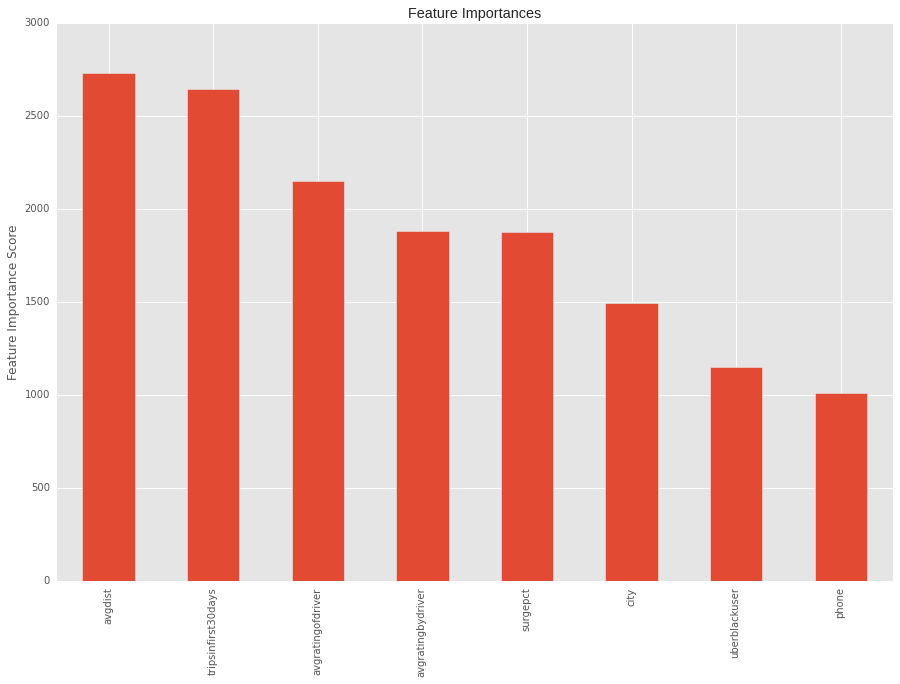

In [682]:
result,xgb1= modelfit(xgb1, data_train[features+['active']].copy(),data_cv[features+['active']].copy(),features,'active',useTrainCV=True)

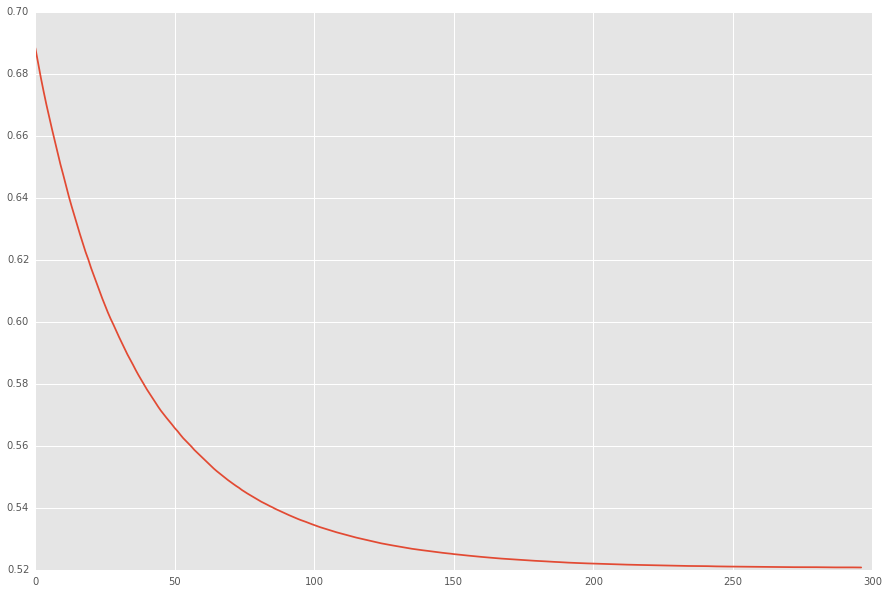

In [684]:
plt.plot(range(297),result.get_values()[:,0])
plt.savefig('logloss_xgb.png')

In [648]:
predictors = [x[:-2].replace('_','') for x in features]
test_added_xgb = test_added[features+['active']].copy()
test_added_xgb.columns = predictors+['active']

In [652]:
preds = xgb1.predict_proba(test_added_xgb[predictors])[:,1]

col_0     0     1
row_0            
0      8223  1128
1      2725  2791
recall: 0.506 
precision: 0.712 
accuracy: 0.741
logloss: 0.521
auc roc: 0.799 


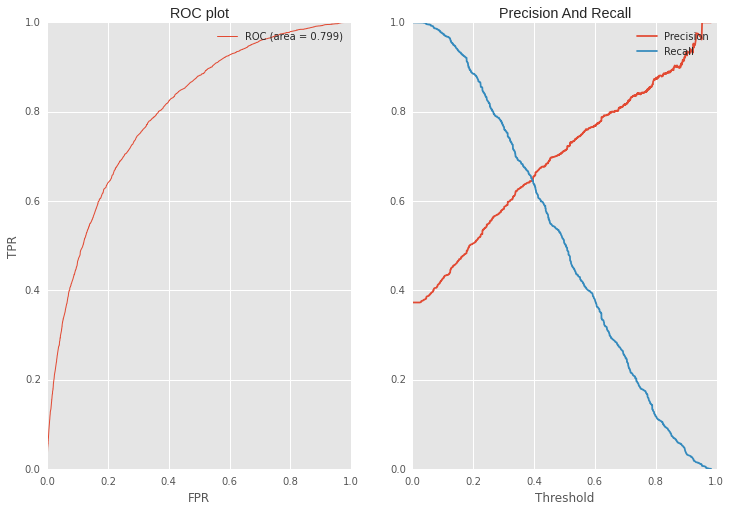

In [663]:
report = performance_report(test_added_xgb,predictors,preds,'active')